In [1]:
import torch
import matplotlib.pyplot as plt

In [2]:
# Imports
trials = 50
n=500
front_door = True
minimise = False
results = torch.load("simulation_bayesimp_ntrial={0}_n={1}_frontdoor={2}_minimise={3}.pt".format(trials,
                                                                                                 n, 
                                                                                                 front_door,
                                                                                                 minimise), 
                     weights_only = True)

# Getting dimensions and names
n_result = len(results)
n_model = int(n_result/trials)

names = []
for i in range(n_result):
    if results[i]['name'] not in names:
        names.append(results[i]['name'])

In [3]:
# Getting evaluations
EYdoX_eval = torch.zeros((len(results[0]['EYdoXeval']), trials, n_model))
for m in range(n_model):
    for t in range(trials):
        EYdoX_eval[:,t,m] = results[trials*m + t]['EYdoXeval'][:,0]

doX_eval = torch.zeros((len(results[0]['doXeval']), trials, n_model))
for m in range(n_model):
    for t in range(trials):
        doX_eval[:,t,m] = results[trials*m + t]['doXeval'][:,0]

In [4]:
# Getting best values
iters = len(results[0]['EYdoXeval'])
best_eval = torch.zeros((iters, trials, n_model))
for m in range(n_model):
    for t in range(trials):
        for i in range(iters):
            if i == 0:
                best_eval[i,t,m] = EYdoX_eval[i,t,m] 
            else:
                if minimise:
                    if EYdoX_eval[i,t,m] < best_eval[:i,t,m].min():
                        best_eval[i,t,m] = EYdoX_eval[i,t,m]
                    else:
                         best_eval[i,t,m] =  best_eval[i-1,t,m]
                else:
                    if EYdoX_eval[i,t,m] > best_eval[:i,t,m].max():
                        best_eval[i,t,m] = EYdoX_eval[i,t,m]
                    else:
                         best_eval[i,t,m] =  best_eval[i-1,t,m]

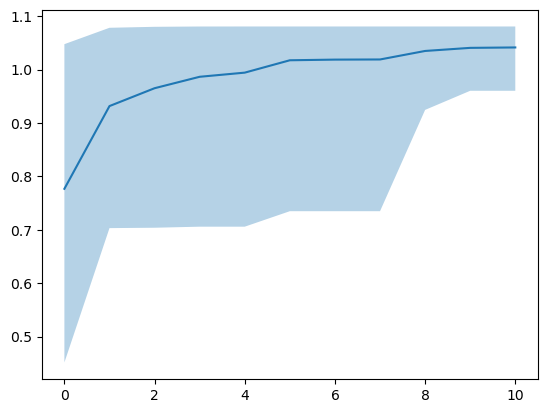

In [5]:
m = 0
i=11
plt.plot(best_eval[...,m].mean(1)[:i])
plt.fill_between(torch.arange(min(len(EYdoX_eval),i)),best_eval[...,m].quantile(0.05,1)[:i],
                 best_eval[...,m].quantile(0.95,1)[:i], alpha = 0.33) 

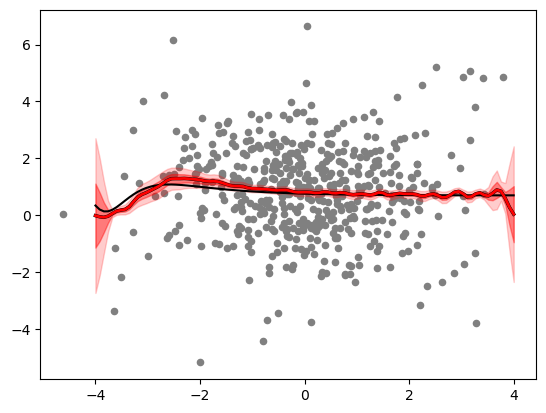

In [6]:
# Getting plot
result = results[0]

# KL plot
z1 = 1.645
z2 = 0.68

X,Y = result['obs_data']
doX,EYdoX = result['int_data']

plt.scatter(X,Y, color = "grey", s = 20)
plt.plot(doX,EYdoX, color = "black")

mu,var = result['post_moments']
plt.fill_between(doX.view(-1),
                 (mu-z1*var**0.5).view(-1),
                 (mu+z1*var**0.5).view(-1),
                alpha = 0.2, color = "red")
plt.fill_between(doX.view(-1),
                 (mu-z2*var**0.5).view(-1),
                 (mu+z2*var**0.5).view(-1),
                alpha = 0.4, color = "red")
plt.plot(doX,mu, color = "black", lw = 2.5)
plt.plot(doX,mu, color = "red", lw = 2)

plt.show()

In [7]:
# Getting RMSEs
print(names)
ind_min, ind_max = -3, 3
use_all_indexes = False  # Set this to True to use all indexes instead of slicing

rmse = torch.zeros(len(results))

for i in range(len(results)):
    doX, EYdoX = results[i]['int_data']
    mu, var = results[i]['post_moments']

    if use_all_indexes:
        # Use all indexes
        mu_slice = mu
        EYdoX_slice = EYdoX
    else:
        # Find the indices where doX crosses ind_min and ind_max
        i_min = (doX < ind_min).nonzero(as_tuple=True)[0][-1]
        i_max = (doX < ind_max).nonzero(as_tuple=True)[0][-1]

        # Slice mu and EYdoX over the range ind_min:ind_max
        mu_slice = mu[i_min:i_max+1]
        EYdoX_slice = EYdoX[i_min:i_max+1]

    # Calculate RMSE for the selected data
    rmse[i] = ((mu_slice - EYdoX_slice)**2).mean()**0.5

# Print the mean RMSE and its standard error
print(rmse.mean(), rmse.var()**0.5 / trials**0.5)

['bayesimp_frontdoor=True_minimise=False']
tensor(0.1910) tensor(0.0119)


tensor([0.0959])
tensor([0.0136])


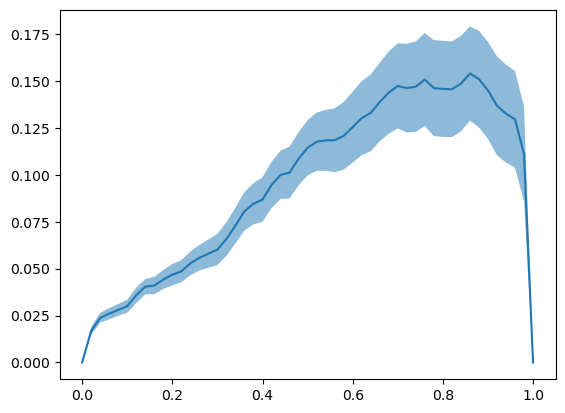

In [8]:
# Getting calibration losses
levels = results[0]['cal_levels']
n_result = len(results)
n_level = len(levels)

post_levels = torch.zeros(100,n_model,n_level)

for t in range(trials):
    for m in range(n_model):
        post_levels[:,m] +=  results[trials*m+t]['post_levels']/trials

cal_loss = (post_levels - levels.T[None]).abs()

print(cal_loss.mean((0,2)))
print(cal_loss.mean(2).var(0)**0.5/trials**0.5)

plot_inds = 2*torch.arange(51)

plt.plot(levels[plot_inds],cal_loss.mean(0).T[plot_inds]);
for i in range(n_model):
    plt.fill_between(levels[plot_inds][:,0],
                     cal_loss.mean(0).T[plot_inds,...,i] - cal_loss.var(0).T[plot_inds,...,i]**0.5/trials**0.5,
                     cal_loss.mean(0).T[plot_inds,...,i] + cal_loss.var(0).T[plot_inds,...,i]**0.5/trials**0.5,
                     alpha = 0.5);